In [2]:
%load_ext autoreload
from mps.state import *

# TIME EVOLUTION

In [3]:
# file: mps/evolution.py

import numpy as np
import scipy.linalg
from numbers import Number
import mps.state
import scipy.sparse as sp
from mps.state import _truncate_vector, DEFAULT_TOLERANCE

## Suzuki-Trotter Decomposition

In Suzuki-Trotter decomposition, the Hamiltonians of the nearest neighbor couplings can be decomposed into two non-commuting parts, $H_{\text{odd}} $ and $ H_{\text{even}} $, so that all additive 2-site operators in each part commute with each other.

Let us consider a simple example of tight binding model with on-site potential and decompose the Hamiltonian into 2-site terms, so that $H=\sum_i h_{i,i+1}$. 
\begin{equation}
h_{i,i+1} = \left(\frac{\omega}{2}  a_i^\dagger a_i \right) + \left(\frac{\omega}{2}  a_{i+1}^\dagger a_{i+1} \right) - \left( t a_{i}^\dagger a_{i+1} + \text{h.c.} \right).
\end{equation}
Since $[h_{i,i+1},h_{i+2,i+3}] = 0$, we can group these terms for even and odd $i$, so that $H = H_{\text{odd}} + H_{\text{even}} $. 

Note that the local term $ a_i^\dagger a_i$ appears only in one the groups for $i=1$ and $i=N$. Therefore we need to add two on-site terms $h_1 = \left(\frac{\omega}{2}  a_1^\dagger a_1 \right) $ and $h_N = \left(\frac{\omega}{2}  a_N^\dagger a_N \right) $, to the corresponding two-site terms. So that $h_{1,2} \rightarrow h_{1,2} + h_1$, and $h_{N-1,N} \rightarrow h_{N-1,N} + h_N$.

And for the first order Suzuki-Trotter decomposition, the evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\end{equation}

`pairwise_unitaries` creates a list of Trotter unitarities corresponding to two-site operators, $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$. The Trotter unitarities associated with $\hat{H}_{\text{odd}}$ and $\hat{H}_{\text{even}}$ are applied separately in consecutive sweeps depending on evenodd value passed to TEBD_sweep class:
$$ U = [U_{1,2}, U_{2,3}, U_{3,4}, \dots ]. $$


In [8]:
# file: mps/evolution.py


def pairwise_unitaries(H, δt):
    return [scipy.linalg.expm((-1j * δt) * H.interaction_term(k)).
                              reshape(H.dimension(k), H.dimension(k+1),
                                      H.dimension(k), H.dimension(k+1))
            for k in range(H.size-1)]

We apply each $U_{i,i+1} = e^{-i h_{i,i+1} \Delta t}$ to two neighbouring tensors, $A_i$ and $A_{i+1}$ simultaneously, as shown below.

<img src="fig_pdf/apply_mpo_to2site.svg" style="max-width: 90%; width: 35em">

The resulting tensor $B$ is a two-site tensor. We split this tensor using the canonical form algorithm defined in [this notebook](File%201c%20-%20Canonical%20form.ipynb). 

In [9]:
# file: mps/evolution.py


def apply_pairwise_unitaries(U, ψ, start, direction, tol=DEFAULT_TOLERANCE):
    """Apply the list of pairwise unitaries U onto an MPS state ψ in
    canonical form. Unitaries are applied onto pairs of sites (i,i+1),
    (i+2,i+3), etc. We start at 'i=start' and move in increasing or
    decreasing order of sites depending on 'direction'
    
    Arguments:
    U         -- List of pairwise unitaries
    ψ         -- State in canonical form
    start     -- First site for applying pairwise unitaries
    direction -- Direction of sweep.
    
    Returns:
    ψ         -- MPS in canonical form"""

    if direction > 0:
        ψ.recenter(start)
        for j in range(start, ψ.size-1, +2):
            AA = np.einsum('ijk,klm,prjl -> iprm', ψ[j], ψ[j+1], U[j])
            ψ.update_canonical_2site(AA, j, j+1, +1, tolerance=tol)
        if j == ψ.size-2:
            return ψ.size-3, -1
        else:
            return ψ.size-2, -1
    else:
        ψ.recenter(start)
        for j in range(start, -1, -2):
            AA = np.einsum('ijk,klm,prjl -> iprm', ψ[j], ψ[j+1], U[j])
            ψ.update_canonical_2site(AA, j, j+1, -1, tolerance=tol)
        if j == 0:
            return 1, +1
        else:
            return 0, +1

In [10]:
# file: mps/evolution.py


class TEBD_evolution(object):
    """TEBD_evolution is a class that continuously updates a quantum state ψ
    evolving it with a Hamiltonian H over intervals of time dt."""
    
    def __init__(self, ψ, H, dt, timesteps=1, order=1, tol=DEFAULT_TOLERANCE):
        """Create a TEBD algorithm to evolve a quantum state ψ with a fixed
        Hamiltonian H.
        
        Arguments:
        ψ         -- Quantum state to be updated. The class keeps a copy.
        H         -- NNHamiltonian for the evolution
        dt        -- Size of each Trotter step
        timesteps -- How many Trotter steps in each call to evolve()
        order     -- Order of the Trotter approximation (1 or 2)
        tol       -- Tolerance in MPS truncation
        """
        self.H = H
        self.dt = float(dt)
        self.timesteps = timesteps
        self.order = order
        self.tolerance = tol
        self.Udt = pairwise_unitaries(H, dt)
        if order == 2:
            self.Udt2 = pairwise_unitaries(H, dt/2)
        if not isinstance(ψ, mps.state.CanonicalMPS):
            ψ = mps.state.CanonicalMPS(ψ, center=0)
        else:
            ψ = ψ.copy()
        self.ψ = ψ
        if ψ.center <= 1:
            self.start = 0
            self.direction = +1
        else:
            self.start = ψ.size-2
            self.direction = -1

    def evolve(self, timesteps=None):
        """Update the quantum state with `timesteps` repetitions of the
        Trotter algorithms."""
        if timesteps is None:
            timesteps = self.timesteps
        for i in range(self.timesteps):
            #print(i)
            if self.order == 1:
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
            else:
                self.start, self.direction = apply_pairwise_unitaries(self.Udt2, self.ψ, self.start, self.direction, tol=self.tolerance)
                self.start, self.direction = apply_pairwise_unitaries(self.Udt, self.ψ, self.start, self.direction, tol=self.tolerance)
                self.start, self.direction = apply_pairwise_unitaries(self.Udt2, self.ψ, self.start, self.direction, tol=self.tolerance)
        return self.ψ

    def state():
        return self.ψ

## Error in Suzuki-Trotter decomposition

In the first order Suzuki-Trotter decomposition, evolution operator becomes
\begin{equation}
e^{-i \hat{H} \Delta t} = e^{-i \hat{H}_{\text{odd}} \Delta t}  e^{-i \hat{H}_{\text{even}} \Delta t} + O(\Delta t^2).
\end{equation}
Note that after $T/\Delta t$ time steps, the accumulated error is in the order of $\Delta t$.
Higher order Suzuki-Trotter decompositions can be used to reduce error.




# Tests

In [11]:
# file: mps/test/test_TEBD.py
from mps.evolution import *


In [12]:
# file: mps/test/test_TEBD.py
import unittest
import mps.state
import mps.tools
from mps.test.tools import *
import scipy.sparse as sp
import scipy.sparse.linalg

def random_wavefunction(n):
    ψ = np.random.rand(n) - 0.5
    return ψ / np.linalg.norm(ψ)

class TestTEBD_sweep(unittest.TestCase):
    
    def test_apply_pairwise_unitaries(self):
        N = 20
        tt = -np.pi/2
        ω = np.pi
        dt = 1e-3
        ψwave = random_wavefunction(N)
        ψ = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        HMat = sp.diags([[tt,0]*(N//2), [ω]+[ω/2]*(N-2)+[ω], [tt,0]*(N//2)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        ψwave_final = sp.linalg.expm_multiply(-1j * dt * HMat, ψwave)
        
        H=make_ti_Hamiltonian(N, [tt * annihilation_op(2) ,tt * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)], 
                              local_term=ω*creation_op(2)@ annihilation_op(2))
        U = pairwise_unitaries(H, dt)
        start = 0
        direction = 1
        apply_pairwise_unitaries(U, ψ, start, direction, tol=DEFAULT_TOLERANCE)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψ.tovector())))
        
    def test_TEBD_evolution_first_order(self):
        #
        #
        #
        N = 19
        t = - np.pi/2
        ω = np.pi
        dt = 1e-6
        Nt = int(1000)
        #ψwave = random_wavefunction(N)
        xx=np.arange(N)
        x0 = int(N//2)
        w0 = 5
        k0 = np.pi/2

        ψwave = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx) 
        ψwave = ψwave / np.linalg.norm(ψwave) 
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        H=make_ti_Hamiltonian(N, [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)], 
                              local_term=ω*creation_op(2)@ annihilation_op(2))
        #for i in range(Nt):
        #    
        #    ψmps = TEBD_sweep(H, ψmps, dt, 1, 0, tol=DEFAULT_TOLERANCE)
        #    ψmps = TEBD_sweep(H, ψmps, dt, -1, 1, tol=DEFAULT_TOLERANCE)
        ψmps = TEBD_evolution(ψmps, H, dt, timesteps=Nt, order=1, tol=DEFAULT_TOLERANCE).evolve()
        Hmat = sp.diags([[t]*(N), ω, [t]*(N)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        
        ψwave_final = sp.linalg.expm_multiply(-1j * dt*Nt * Hmat, ψwave)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps.tovector())))
                
        
    def test_TEBD_evolution_second_order(self):
        #
        #
        #
        N = 21
        t = 0.1
        ω = 0.5
        dt = 1e-6
        Nt = int(1000)
        #ψwave = random_wavefunction(N)
        xx=np.arange(N)
        x0 = int(N//2)
        w0 = 5
        k0 = np.pi/2

        ψwave = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx) 
        ψwave = ψwave / np.linalg.norm(ψwave) 
        ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
        # We use the tight-binding Hamiltonian
        H=make_ti_Hamiltonian(N, [t * annihilation_op(2) , t * creation_op(2)], 
                            [creation_op(2), annihilation_op(2)], 
                              local_term=ω*creation_op(2)@ annihilation_op(2))
        #for i in range(Nt):
        #    
        #    ψmps = TEBD_sweep(H, ψmps, dt, 1, 0, tol=DEFAULT_TOLERANCE)
        #    ψmps = TEBD_sweep(H, ψmps, dt, -1, 1, tol=DEFAULT_TOLERANCE)
        ψmps = TEBD_evolution(ψmps, H, dt, timesteps=Nt, order=2, tol=DEFAULT_TOLERANCE).evolve()
        Hmat = sp.diags([[t]*(N), ω, [t]*(N)],
                  offsets=[-1,0,+1],
                  shape=(N,N),
                  dtype=np.complex128)
        
        ψwave_final = sp.linalg.expm_multiply(-1j * dt*Nt * Hmat, ψwave)
        
        self.assertTrue(similar(abs(mps.state.wavepacket(ψwave_final).tovector()), 
                                abs(ψmps.tovector())))
                


    

In [13]:
%autoreload
suite1 = unittest.TestLoader().loadTestsFromNames(['__main__.TestTEBD_sweep'])
unittest.TextTestRunner(verbosity=2).run(suite1);

test_TEBD_evolution_first_order (__main__.TestTEBD_sweep) ... ok
test_TEBD_evolution_second_order (__main__.TestTEBD_sweep) ... ok
test_apply_pairwise_unitaries (__main__.TestTEBD_sweep) ... ok

----------------------------------------------------------------------
Ran 3 tests in 11.758s

OK


# Error Analysis

In [14]:
N = 19
tt = -np.pi/2
ω = np.pi

xx=np.arange(N)
x0 = int(N//2)
w0 = 5
k0 = np.pi/2

ψwave = np.exp(-(xx-x0)**2 / w0**2 + 1j * k0*xx) #random_wavefunction(N)
ψwave = ψwave / np.linalg.norm(ψwave) 
ψmps = CanonicalMPS(mps.state.wavepacket(ψwave))
# We use the tight-binding Hamiltonian
H=make_ti_Hamiltonian(N, [tt * annihilation_op(2) ,tt * creation_op(2)], 
                    [creation_op(2), annihilation_op(2)], 
                      local_term=ω* annihilation_op(2) @ creation_op(2))

O = mps.evolution.creation_op(2)@ mps.evolution.annihilation_op(2)

## Truncation error:

In [15]:
dt = 1
U = pairwise_unitaries(H, dt)

HMat = sp.diags([[tt,0]*(N//2), [ω]+[ω/2]*(N-2)+[0], [tt,0]*(N//2)],
          offsets=[-1,0,+1],
          shape=(N,N),
          dtype=np.complex128)
ψwave_final = sp.linalg.expm_multiply(-1j * dt * HMat, ψwave)
exact_mps = mps.state.wavepacket(ψwave_final)

start = 0
direction = 1

In [16]:
tol_list = 0.01*np.arange(100,1,-1) #[0.2, 1e-1, 4e-2, 1e-2, 1e-3, 1e-16]
overlap_list =[]
for tolerance in tol_list:
    ψ = ψmps.copy()
    apply_pairwise_unitaries(U, ψ, start, direction, tol=tolerance)
    overlap_list.append(abs(1-mps.expectation.scprod(exact_mps,ψ)))


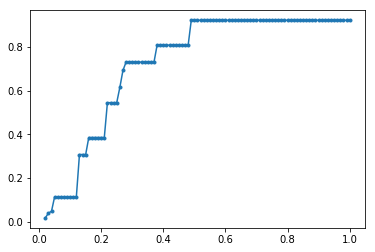

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tol_list, overlap_list, ".-")

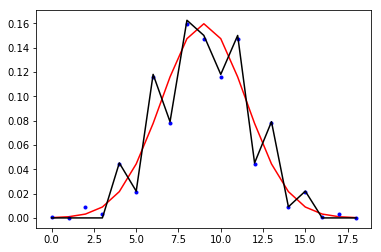

In [18]:
plt.plot(abs(ψwave)**2, "r-")
plt.plot(abs(ψwave_final)**2, "b.")
O = mps.evolution.creation_op(2)@ mps.evolution.annihilation_op(2)
plt.plot([abs(mps.expectation.expectation1_non_canonical(ψ, O, site)) for site in range(N)] , "k-")

## Error due to Trotter Decomposition:

In [19]:
HMat = sp.diags([[tt]*(N), [ω]*(N), [tt]*(N)],
          offsets=[-1,0,+1],
          shape=(N,N),
          dtype=np.complex128)



### 1st order:

In [20]:
Ntotal = 1.0
ψwave_final = sp.linalg.expm_multiply(-1j * Ntotal * HMat, ψwave)
exact_mps = mps.state.wavepacket(ψwave_final)

Nt_list = np.array([1000,500,250,200,100, 10]) #100 * np.arange(1,5)
overlap_list = []
overlap2_list = []
error_list = []
error2_list = []
for Nt in Nt_list:
    dt = Ntotal/Nt
    ψ = ψmps.copy()
    ψ = TEBD_evolution(ψ, H, dt, timesteps=Nt, order=1, tol=DEFAULT_TOLERANCE).evolve()   
    overlap_list.append(abs(1-mps.expectation.scprod(exact_mps,ψ)))
    error_list.append(np.sum(np.absolute([mps.expectation.expectation1_non_canonical(ψ, O, site) 
                              for site in range(N)]-abs(ψwave_final)**2)))
    ψ2 = ψmps.copy()
    ψ2 = TEBD_evolution(ψ2, H, dt, timesteps=Nt, order=2, tol=DEFAULT_TOLERANCE).evolve() 
    overlap2_list.append(abs(1-mps.expectation.scprod(exact_mps,ψ2)))
    error2_list.append(np.sum(np.absolute([mps.expectation.expectation1_non_canonical(ψ2, O, site) 
                              for site in range(N)]-abs(ψwave_final)**2)))



C:\Users\JuanJose\Miniconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


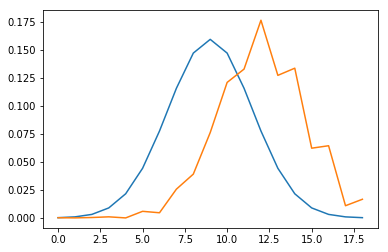

In [21]:
plt.plot([mps.expectation.expectation1_non_canonical(ψmps, O, site) for site in range(N)])
plt.plot([mps.expectation.expectation1_non_canonical(ψ, O, site) for site in range(N)])

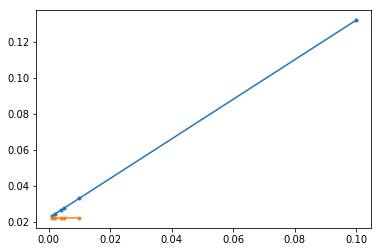

In [22]:
plt.plot(Ntotal/Nt_list, [abs(error) for error in error_list], ".-")
plt.plot(Ntotal/Nt_list[:-1], [abs(error) for error in error2_list][:-1], ".-")

#plt.plot(Ntotal/Nt_list, overlap2_list, "r.-")

In [23]:
error2_list

[0.022273492642575783,
 0.022273240905669123,
 0.022272226732226025,
 0.022272065616025172,
 0.02227533813637677,
 0.023734782588045546]

In [24]:
overlap2_list

[0.010051985919505709,
 0.010051965239625453,
 0.010051882725182948,
 0.010051820977192823,
 0.010051309112706932,
 0.009991397125261509]

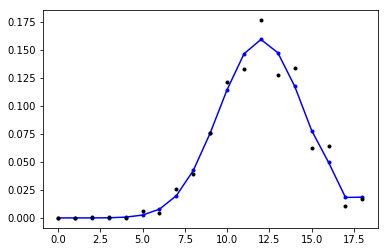

In [25]:
#plt.plot(abs(ψwave)**2, "r-")
plt.plot(abs(ψwave_final)**2, "b.-")
O = mps.evolution.creation_op(2)@ mps.evolution.annihilation_op(2)
plt.plot([mps.expectation.expectation1_non_canonical(ψ, O, site) for site in range(N)] , "k.")
#plt.plot([mps.expectation.expectation1_non_canonical(ψ2, O, site) for site in range(N)] , "r.")

### 2nd order: